In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, mean_absolute_error
from sklearn.preprocessing import QuantileTransformer
from scipy import stats
from scipy.stats import uniform
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/DL/UTS/RegresiUTSTelkom.csv'
df = pd.read_csv(file_path, header=None)

num_features = 90
columns = ['Year'] + [f'Feature{i+1}' for i in range(num_features)]

df.columns = columns
print(df.head(7))

   Year  Feature1  Feature2  Feature3  Feature4  Feature5  Feature6  Feature7  \
0  2001  49.94357  21.47114  73.07750   8.74861 -17.40628 -13.09905 -25.01202   
1  2001  48.73215  18.42930  70.32679  12.94636 -10.32437 -24.83777   8.76630   
2  2001  50.95714  31.85602  55.81851  13.41693  -6.57898 -18.54940  -3.27872   
3  2001  48.24750  -1.89837  36.29772   2.58776   0.97170 -26.21683   5.05097   
4  2001  50.97020  42.20998  67.09964   8.46791 -15.85279 -16.81409 -12.48207   
5  2001  50.54767   0.31568  92.35066  22.38696 -25.51870 -19.04928  20.67345   
6  2001  50.57546  33.17843  50.53517  11.55217 -27.24764  -8.78206 -12.04282   

   Feature8  Feature9  ...  Feature81  Feature82  Feature83  Feature84  \
0 -12.23257   7.83089  ...   13.01620  -54.40548   58.99367   15.37344   
1  -0.92019  18.76548  ...    5.66812  -19.68073   33.04964   42.87836   
2  -2.35035  16.07017  ...    3.03800   26.05866  -50.92779   10.93792   
3 -10.34124   3.55005  ...   34.57337 -171.70734  -16.9

Skewness of features:
Year        -1.731526
Feature1    -0.895418
Feature2    -0.860272
Feature3    -0.153237
Feature4     0.974355
               ...   
Feature86   -0.302343
Feature87   -0.781158
Feature88    1.362913
Feature89    1.349357
Feature90    1.140860
Length: 91, dtype: float64


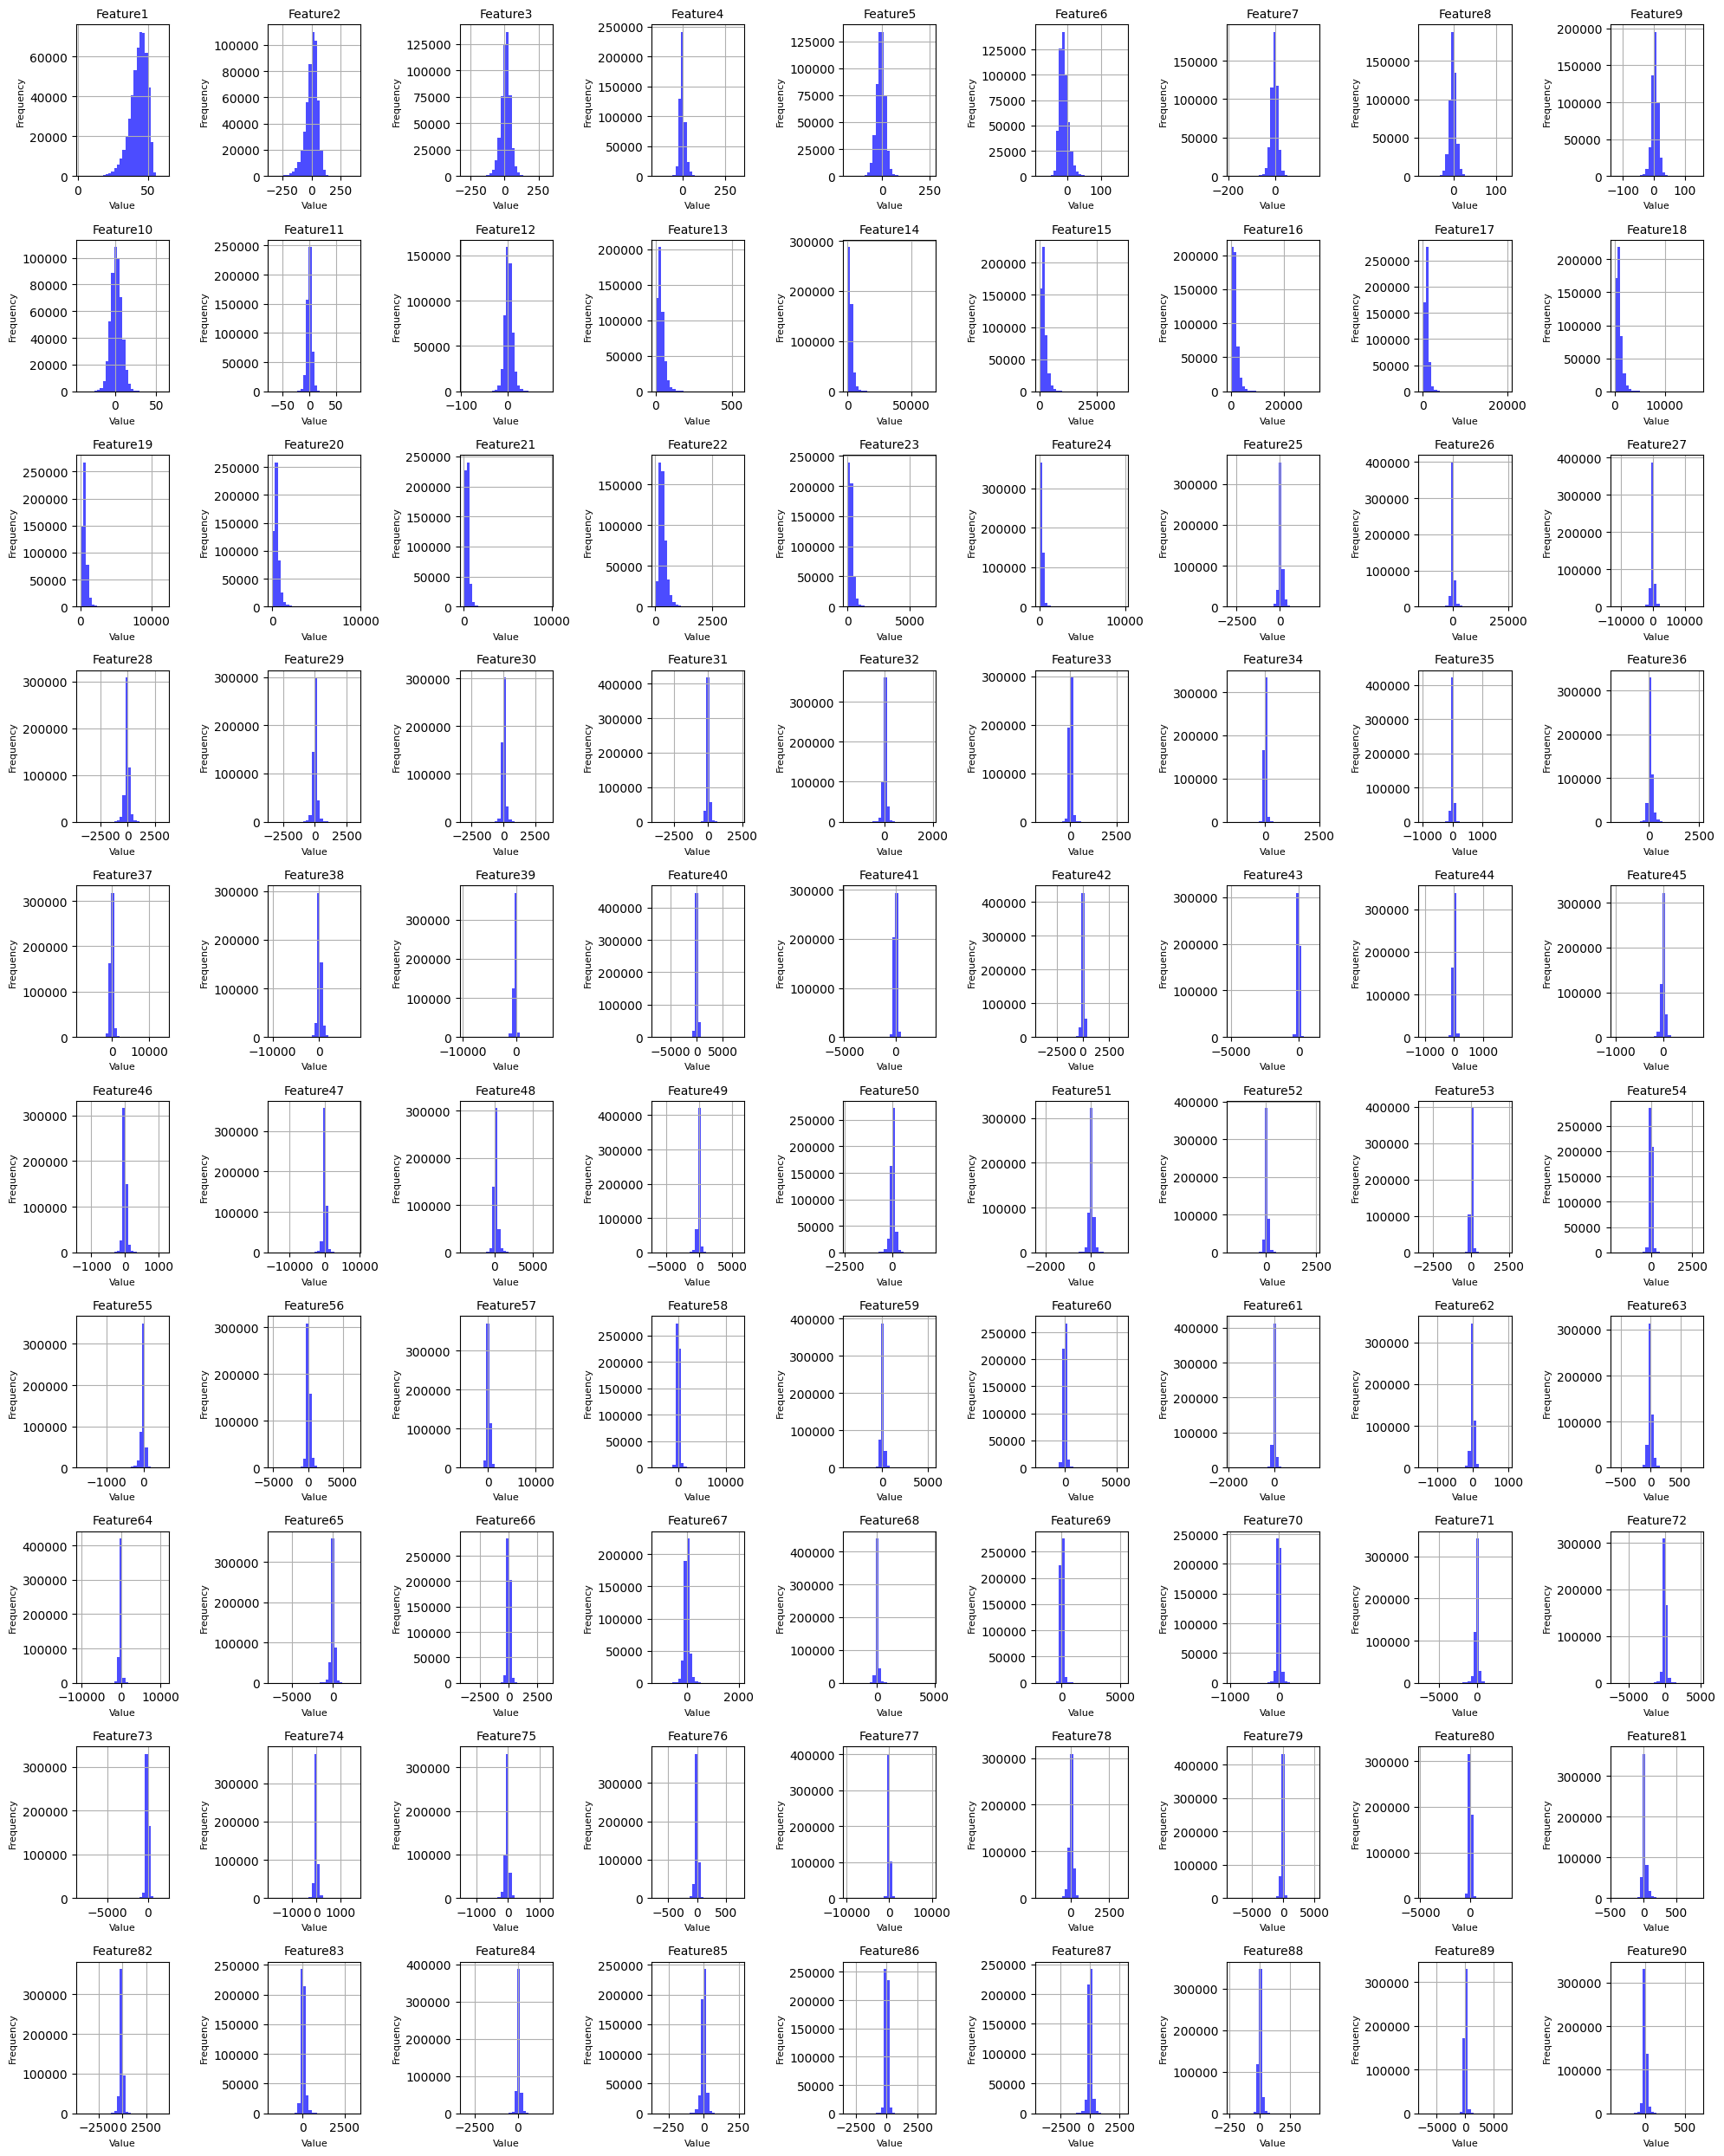

In [ ]:
skewness = df.skew()
print("Skewness of features:")
print(skewness)

# Create a 10x9 grid for 90 features
fig, axes = plt.subplots(10, 9, figsize=(20, 25))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Loop over features and plot histograms
for i, feature in enumerate(df.columns[1:]):  # Skipping 'Year' column
    df[feature].hist(ax=axes[i], bins=30, color='blue', alpha=0.7)
    axes[i].set_title(f'{feature}', fontsize=10)
    axes[i].set_xlabel('Value', fontsize=8)
    axes[i].set_ylabel('Frequency', fontsize=8)

# Adjust layout for better spacing
plt.subplots_adjust(hspace=0.6, wspace=0.3)

# Automatically adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

Skewness after Quantile Transformation:
Feature1    -0.021087
Feature2    -0.042447
Feature3    -0.011289
Feature4    -0.014959
Feature5     0.014533
               ...   
Feature86   -0.036386
Feature87   -0.024524
Feature88    0.037028
Feature89    0.009877
Feature90    0.030503
Length: 90, dtype: float64


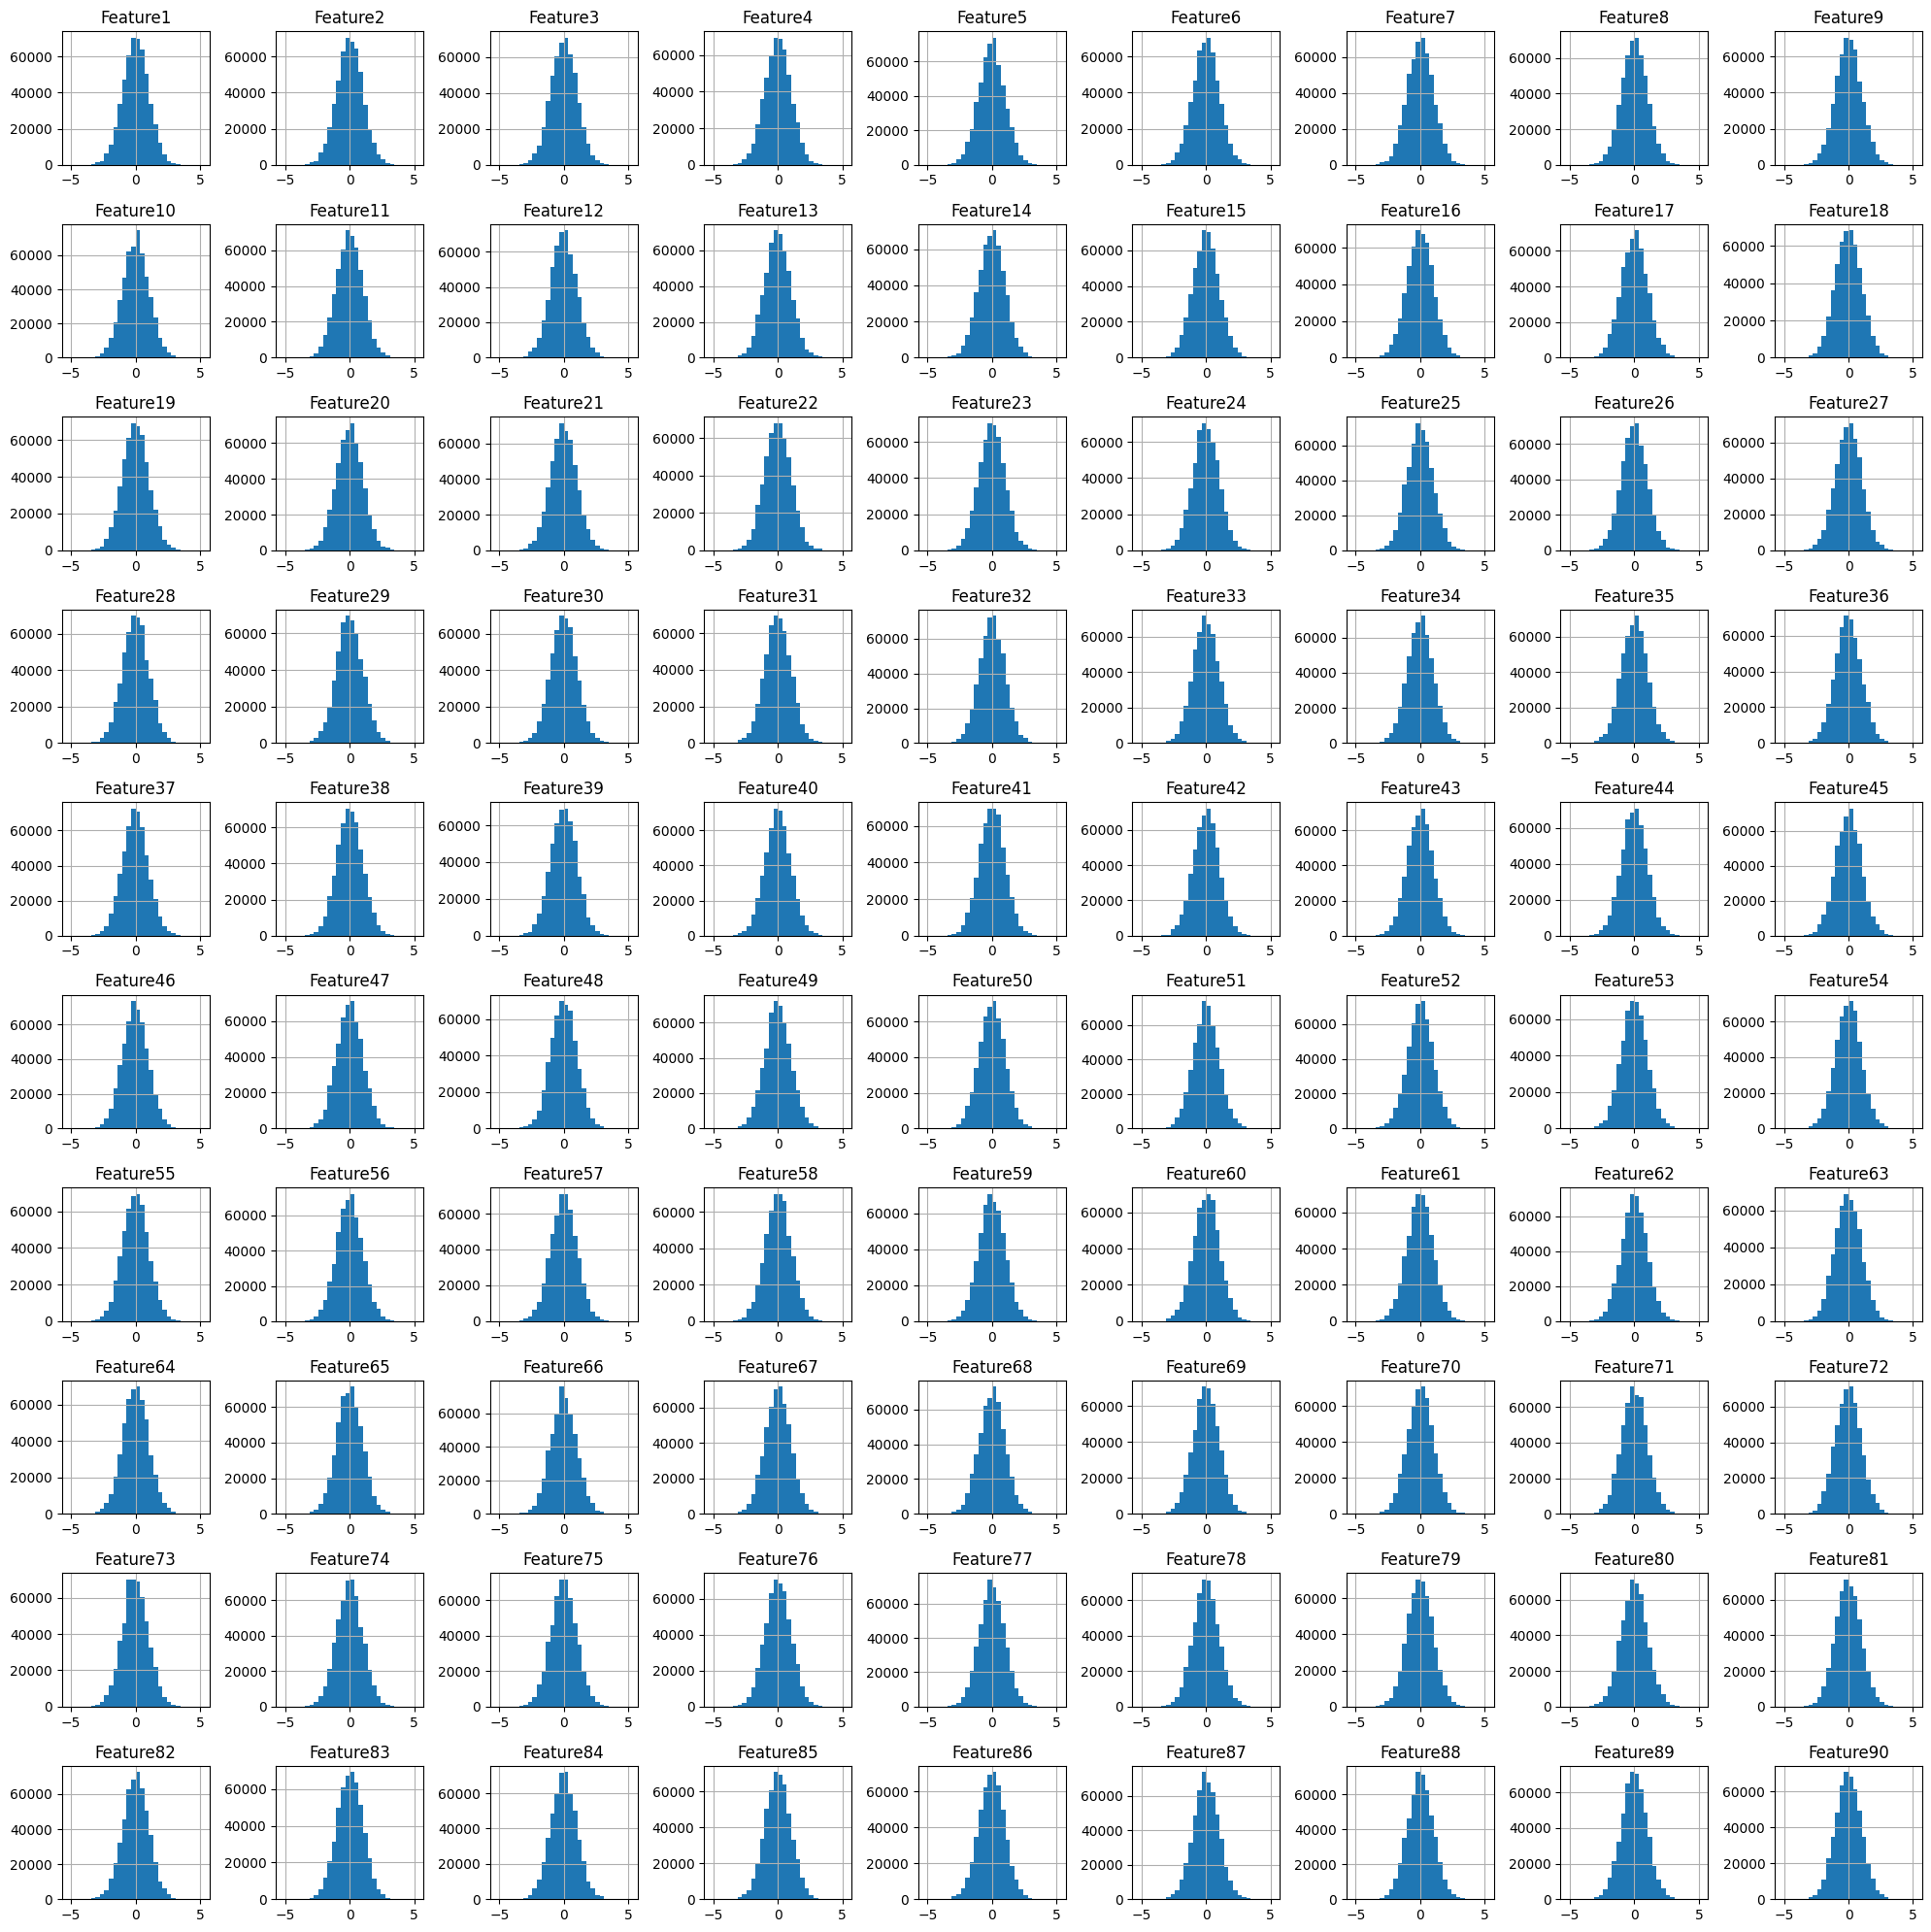

In [ ]:
# Copy to avoid modifying the original df
df_quantile = df.copy()

# Apply Quantile Transformation to the features excluding 'Year'
quantile_transformer = QuantileTransformer(output_distribution='normal')
df_transformed_scaled = df_quantile.drop(columns=['Year'])

# Apply Quantile Transformation
df_quantile_transformed = quantile_transformer.fit_transform(df_transformed_scaled)

# Convert back to DataFrame for easier interpretation
df_quantile_transformed = pd.DataFrame(df_quantile_transformed, columns=df_transformed_scaled.columns)

# Check the skewness after applying Quantile Transformation
transformed_skewness_quantile = df_quantile_transformed.skew()
print("Skewness after Quantile Transformation:")
print(transformed_skewness_quantile)

# Visualize the distribution of transformed features after Quantile Transformation
df_quantile_transformed.hist(bins=30, figsize=(20, 20))
plt.tight_layout()
plt.show()

In [ ]:
# Calculate the Z-scores of the transformed data (after Quantile Transformation)
z_scores = np.abs(stats.zscore(df_quantile_transformed))

# Identify outliers: Z-score > 3 (outliers are typically Z-scores > 3)
outlier_indices = np.where(z_scores > 3)

# Get the row indices and column indices where the outliers are located
outlier_rows = outlier_indices[0]
outlier_cols = outlier_indices[1]

# Map the column indices to feature names
outlier_features = df_quantile_transformed.columns[outlier_cols]

# Create a DataFrame to display the outliers with their corresponding feature names and values
outlier_data = pd.DataFrame({
    'Row': outlier_rows,
    'Feature': outlier_features,
    'Outlier Value': df_quantile_transformed.values[outlier_rows, outlier_cols]
})

# Display all the outliers
print(outlier_data)

           Row    Feature  Outlier Value
0           10  Feature41       3.060559
1           13  Feature47       5.199338
2           13  Feature89      -3.102267
3           92  Feature68       3.105710
4           96  Feature71       3.168231
...        ...        ...            ...
131817  515049  Feature88       3.024533
131818  515089  Feature56      -3.041805
131819  515091  Feature55       3.013479
131820  515109  Feature36      -3.159589
131821  515121  Feature77      -3.082681

[131822 rows x 3 columns]


In [ ]:
# Apply StandardScaler to the data (after Quantile Transformation)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_quantile_transformed)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
y = df['Year']  # Assuming 'Year' is your target column
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Check the shape of the scaled data
print(f"Shape of X_train: {X_train.shape}, X_test: {X_test.shape}")

Shape of X_train: (412104, 90), X_test: (103027, 90)


In [ ]:
# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'hidden_layer_sizes': [(100,), (50, 50), (100, 50), (200, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam'],
    'alpha': uniform(0.0001, 1),
    'learning_rate_init': uniform(0.0001, 0.01),
    'max_iter': [500, 1000, 1500],
    'early_stopping': [True],
    'batch_size': [32, 64, 128],
}

# Initialize the MLP model with tolerance for early stopping
mlp_model = MLPRegressor(random_state=42, tol=0.0001)  # tol is the tolerance for early stopping

# Set up the RandomizedSearchCV with 3-fold cross-validation
random_search = RandomizedSearchCV(estimator=mlp_model, param_distributions=param_dist,
                                   n_iter=20, cv=5, n_jobs=-1, verbose=2,
                                   scoring='neg_mean_squared_error', random_state=42)

# Fit RandomizedSearchCV to the smaller subset of the training data
random_search.fit(X_train_subset, y_train_subset)

# Print the best hyperparameters found
print(f"Best hyperparameters: {random_search.best_params_}")

# Get the best model from the search
best_mlp_model = random_search.best_estimator_

# Evaluate the best model on the full test set (X_test, y_test)
test_score = best_mlp_model.score(X_test, y_test)
print(f"Test R² Score of the best model: {test_score:.4f}")

# Predict on the full test set
y_pred = best_mlp_model.predict(X_test)

# Compute MSE (Mean Squared Error) first
mse = mean_squared_error(y_test, y_pred)

# Then compute RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)

# Print RMSE
print(f"RMSE: {rmse:.4f}")